In [ ]:
!pip install transformers torch matplotlib wordcloud

In [4]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
import json
import torch
from transformers import BertTokenizer, BertModel
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Cargar las stopwords en español
stop_words = set(stopwords.words('spanish'))

# Función para limpiar tokens
#def limpiar_tokens(tokens):
#    return [token for token in tokens if token.lower() not in stop_words and token.isalpha()]

def limpiar_tokens(tokens):
    palabras_limpias = []
    for token in tokens:
        if token.lower() not in stop_words and token.isalpha():
            palabras_limpias.append(token)
        elif token.lower() == 'acapulco':  # Asegurarnos de incluir "Acapulco"
            palabras_limpias.append(token)
    return palabras_limpias


# Cargar el modelo preentrenado y el tokenizador
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Archivo JSONL de entrada
archivo_path = './02_news/noticias_huracan_otis.jsonl'

# Leer el archivo y procesar los textos
palabras_ponderadas = Counter()

with open(archivo_path, 'r', encoding='utf-8') as file:
    for linea in file:
        noticia = json.loads(linea)
        texto = noticia['content']

        # Tokenizar el texto
        inputs = tokenizer(texto, return_tensors='pt', truncation=True, max_length=512)

        # Obtener los embeddings del modelo
        with torch.no_grad():
            outputs = model(**inputs)

        # Obtener la última capa oculta de los embeddings
        last_hidden_states = outputs.last_hidden_state

        # Calcular la media de los embeddings para obtener el vector representativo del texto
        texto_embedding = last_hidden_states.mean(dim=1).squeeze()

        # Convertir a numpy y listar las palabras más representativas
        texto_embedding_np = texto_embedding.numpy()
        palabras = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Limpiar los tokens
        palabras_limpias = limpiar_tokens(palabras)

        for palabra in palabras_limpias:
            palabras_ponderadas[palabra] += 1  # Esto sigue siendo una simplificación


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


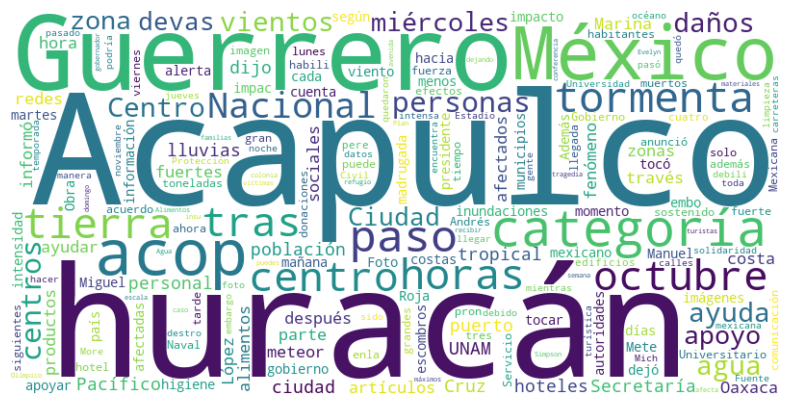

In [21]:
# Reemplazar 'Aca' con 'Acapulco'
if 'Aca' in palabras_ponderadas:
    palabras_ponderadas['Acapulco'] = palabras_ponderadas.pop('Aca')
    
for palabra in list(palabras_ponderadas.keys()):
    if len(palabra) <= 3:
        del palabras_ponderadas[palabra]
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palabras_ponderadas)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [22]:
from wordcloud import WordCloud
import os

# Asegurarse de que la carpeta de destino existe, si no, crearla
directory = "./02_news/wordcloud_news"
if not os.path.exists(directory):
    os.makedirs(directory)

# Supongamos que 'palabras_ponderadas' es el Counter actualizado con 'Acapulco'
# Doblar el tamaño de la imagen de la nube de palabras
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(palabras_ponderadas)

# Guardar la imagen de la nube de palabras
wordcloud.to_file(os.path.join(directory, 'wordcloud.jpeg'))

# Ahora, para guardar la lista de palabras ordenada:
palabras_ordenadas = palabras_ponderadas.most_common()

# Guardar la lista en un archivo de texto
with open(os.path.join(directory, 'palabras_ponderadas.txt'), 'w') as file:
    for palabra, frecuencia in palabras_ordenadas:
        file.write(f'{palabra}: {frecuencia}\n')



In [18]:
import json
import torch
from transformers import BertTokenizer, BertModel
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Cargar las stopwords en español
stop_words = set(stopwords.words('spanish'))

def limpiar_tokens(tokens):
    palabras_limpias = []
    for token in tokens:
        if token.lower() not in stop_words and token.isalpha():
            palabras_limpias.append(token)
        elif token.lower() == 'acapulco':  # Asegurarnos de incluir "Acapulco"
            palabras_limpias.append(token)
    return palabras_limpias

# Cargar el modelo preentrenado y el tokenizador
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Archivo JSONL de entrada
archivo_path = './02_news/noticias_huracan_otis.jsonl'

# Crear un diccionario con contadores para cada día en el rango
#rango_fechas = ["2023-10-{}".format(i) for i in range(24, 32)] + ["2023-11-{}".format(i) for i in range(1, 6)]
rango_fechas = ["2023-10-{}".format(str(i).zfill(2)) for i in range(24, 32)] + ["2023-11-{}".format(str(i).zfill(2)) for i in range(1, 6)]

palabras_por_fecha = {fecha: Counter() for fecha in rango_fechas}

with open(archivo_path, 'r', encoding='utf-8') as file:
    for linea in file:
        noticia = json.loads(linea)
        texto = noticia['content']

        # Verificar si el campo 'date' está presente y si la fecha está en el rango deseado
        fecha_noticia = noticia.get('date')
        if fecha_noticia and fecha_noticia in rango_fechas:
            
            # Tokenizar el texto
            inputs = tokenizer(texto, return_tensors='pt', truncation=True, max_length=512)

            # Obtener los embeddings del modelo
            with torch.no_grad():
                outputs = model(**inputs)

            # Obtener la última capa oculta de los embeddings
            last_hidden_states = outputs.last_hidden_state

            # Convertir a numpy y listar las palabras más representativas
            palabras = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

            # Limpiar los tokens
            palabras_limpias = limpiar_tokens(palabras)
            for palabra in palabras_limpias:
                palabras_por_fecha[fecha_noticia][palabra] += 1

            if 'Aca' in palabras_por_fecha[fecha_noticia]:
                palabras_por_fecha[fecha_noticia]['Acapulco'] = palabras_por_fecha[fecha_noticia].pop('Aca')



[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


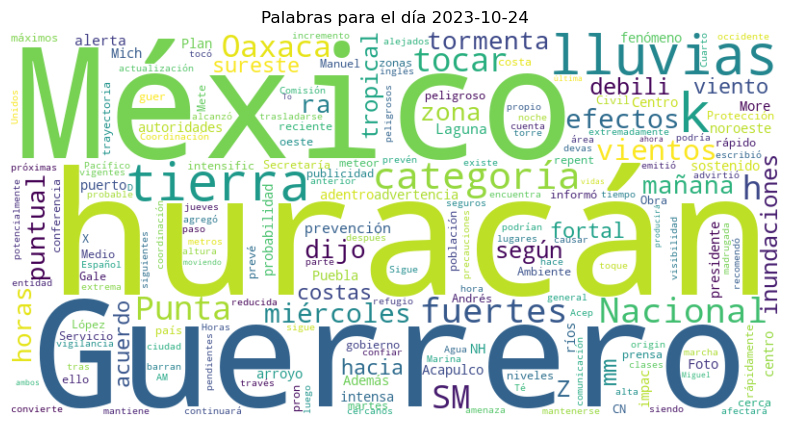

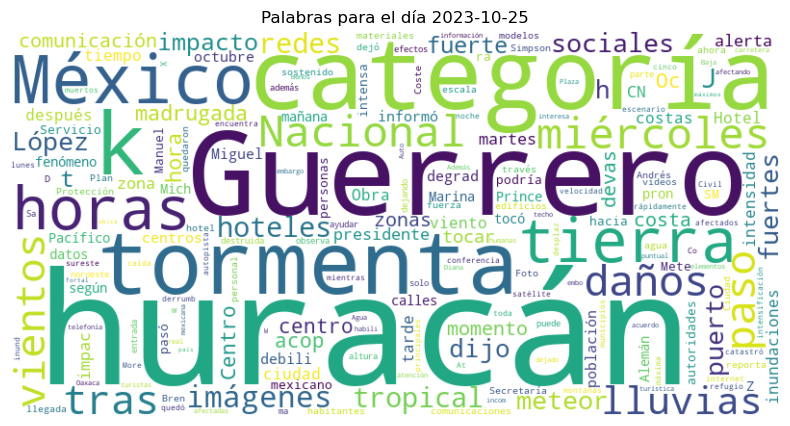

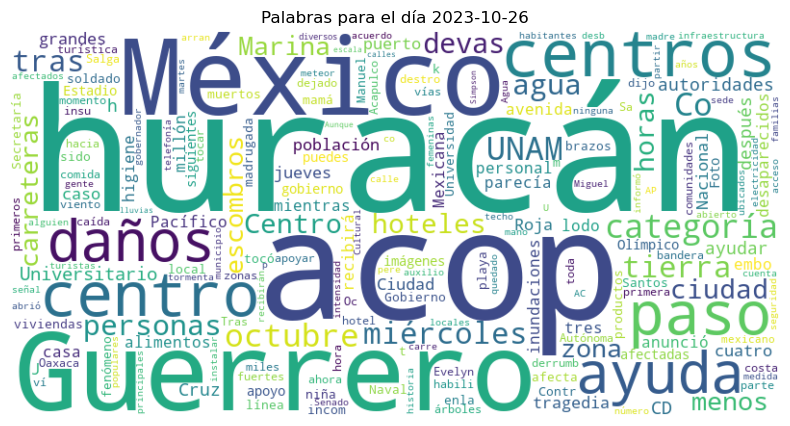

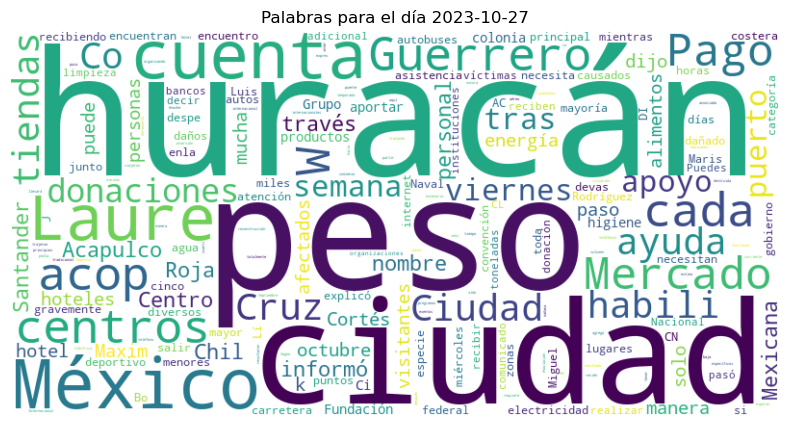

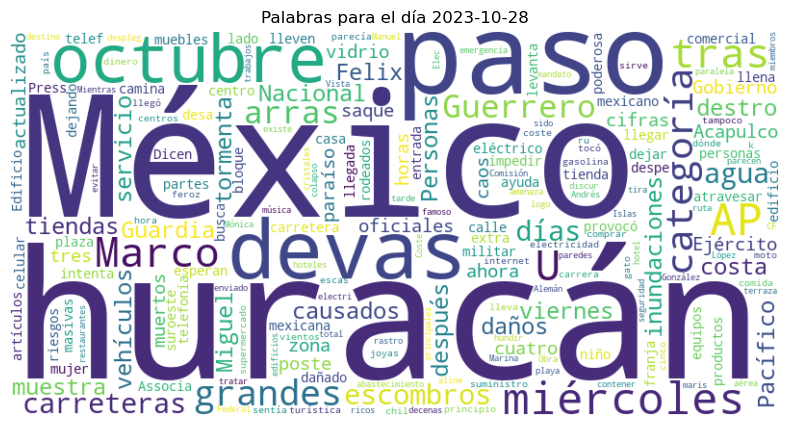

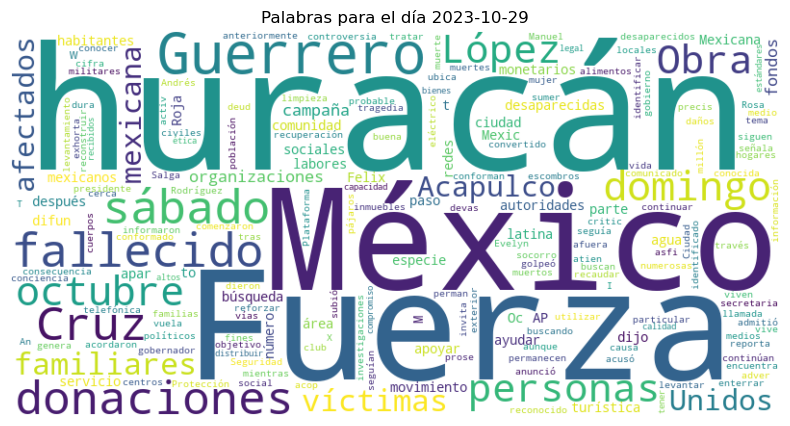

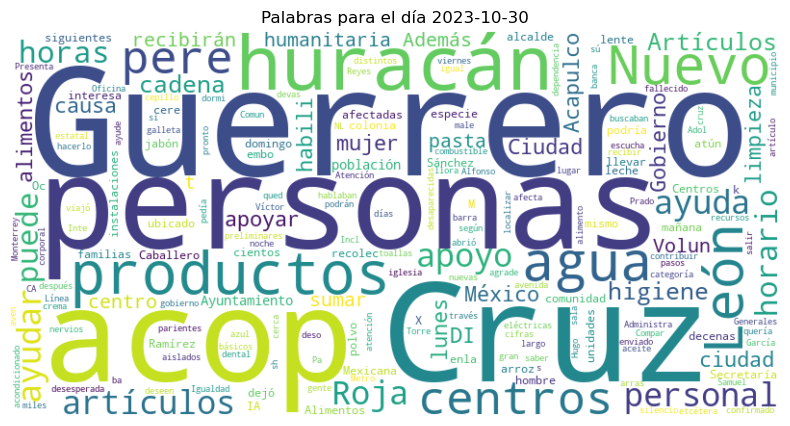

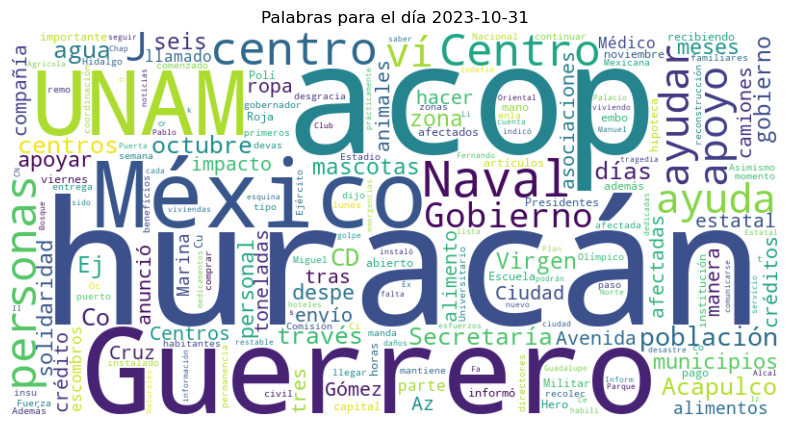

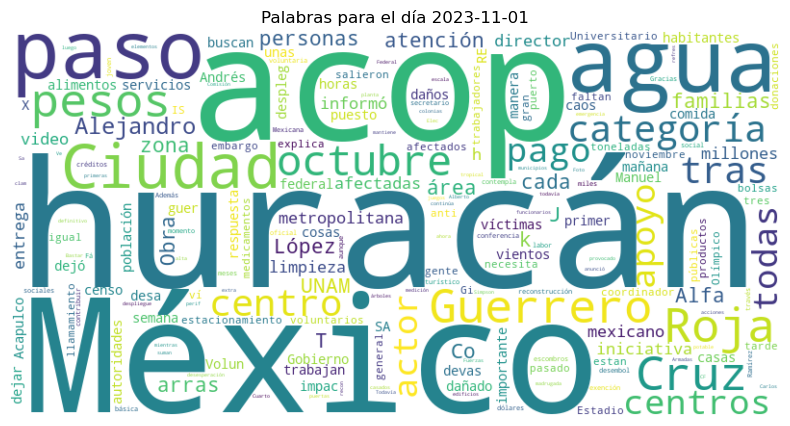

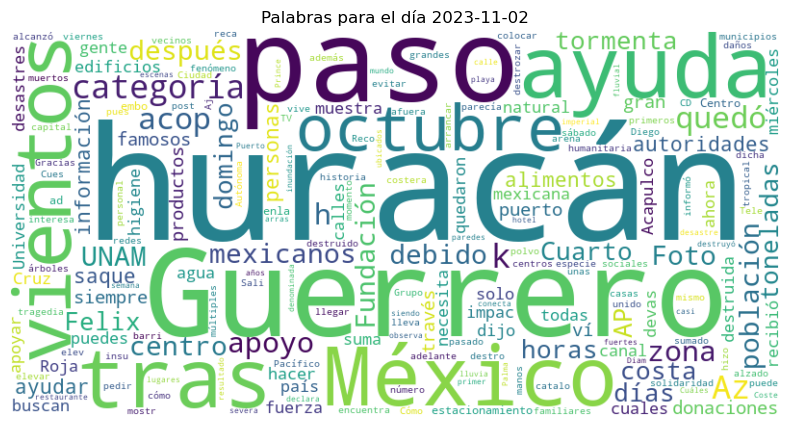

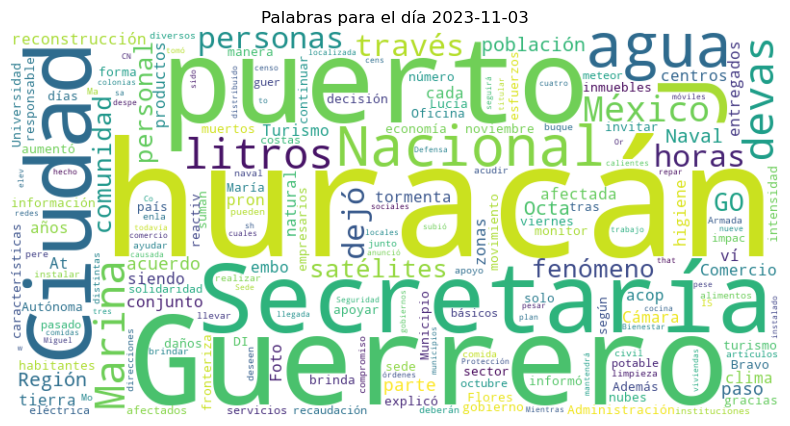

Error generando nube de palabras para el día 2023-11-04: We need at least 1 word to plot a word cloud, got 0.
Error generando nube de palabras para el día 2023-11-05: We need at least 1 word to plot a word cloud, got 0.


In [19]:
# Generar y mostrar una nube de palabras para cada fecha
for fecha, palabras in palabras_por_fecha.items():
    # Reemplazar 'Aca' con 'Acapulco'
    if 'Aca' in palabras:
        palabras['Acapulco'] = palabras.pop('Aca')
    # Eliminar palabras de 3 dígitos
    for palabra in list(palabras.keys()):
        if len(palabra) == 3:
            del palabras[palabra]
        
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palabras)
        
        plt.figure(figsize=(10, 5))
        plt.title(f"Palabras para el día {fecha}")
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        
        # Guardar la imagen
        nombre_imagen = fecha.replace('-', '_')
        directorio_guardado = './02_news/wordcloud_news'
        if not os.path.exists(directorio_guardado):
            os.makedirs(directorio_guardado)
        
        plt.savefig(f"{directorio_guardado}/{nombre_imagen}.png")
        plt.show()
        
    except Exception as e:
        print(f"Error generando nube de palabras para el día {fecha}: {e}")

In [24]:
import json
from collections import Counter

# Ruta al archivo jsonl
archivo_path = './02_news/noticias_huracan_otis.jsonl'

# Crear un contador para las fechas
contador_fechas = Counter()

# Leer el archivo y contar las noticias por fecha
with open(archivo_path, 'r', encoding='utf-8') as file:
    for linea in file:
        noticia = json.loads(linea)
        fecha = noticia.get('date')  # Asegúrate de que el campo de la fecha en el JSON sea 'date'
        if fecha:  # Verificar si la fecha está presente
            contador_fechas[fecha] += 1

# Mostrar el conteo de noticias por fecha
for fecha, conteo in contador_fechas.items():
    print(f"Fecha: {fecha}, Noticias: {conteo}")


Fecha: 2023-10-27, Noticias: 8
Fecha: 2023-10-25, Noticias: 41
Fecha: 2023-10-26, Noticias: 20
Fecha: 2023-10-29, Noticias: 2
Fecha: 2023-10-24, Noticias: 6
Fecha: 2023-10-28, Noticias: 3
Fecha: 2023-11-03, Noticias: 7
Fecha: 2023-10-31, Noticias: 12
Fecha: 2023-10-15, Noticias: 1
Fecha: 2023-11-01, Noticias: 5
Fecha: 2022-05-29, Noticias: 1
Fecha: 2023-10-30, Noticias: 4
Fecha: 2023-11-02, Noticias: 6
Fecha: 2005-10-01, Noticias: 1
Fecha: 2022-05-30, Noticias: 1
Fecha: 2021-10-05, Noticias: 1
Fecha: 2020-11-24, Noticias: 1
Fecha: 2017-10-05, Noticias: 1


In [25]:
# Ordenar las fechas
fechas_ordenadas = sorted(contador_fechas.items(), key=lambda x: x[0])

# Imprimir las fechas ordenadas con su respectivo conteo
for fecha, conteo in fechas_ordenadas:
    print(f"Fecha: {fecha}, Noticias: {conteo}")


Fecha: 2005-10-01, Noticias: 1
Fecha: 2017-10-05, Noticias: 1
Fecha: 2020-11-24, Noticias: 1
Fecha: 2021-10-05, Noticias: 1
Fecha: 2022-05-29, Noticias: 1
Fecha: 2022-05-30, Noticias: 1
Fecha: 2023-10-15, Noticias: 1
Fecha: 2023-10-24, Noticias: 6
Fecha: 2023-10-25, Noticias: 41
Fecha: 2023-10-26, Noticias: 20
Fecha: 2023-10-27, Noticias: 8
Fecha: 2023-10-28, Noticias: 3
Fecha: 2023-10-29, Noticias: 2
Fecha: 2023-10-30, Noticias: 4
Fecha: 2023-10-31, Noticias: 12
Fecha: 2023-11-01, Noticias: 5
Fecha: 2023-11-02, Noticias: 6
Fecha: 2023-11-03, Noticias: 7
